In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
ROUND_NUMBER = 20 

In [2]:
df_original = pd.read_excel('./input_full.xlsx')
df_original = df_original[df_original['Date'].dt.month ==
                          10]  # Используем только данные за 4ый квартал
df_original['Year'] = df_original['Date'].dt.year
df_original = df_original[df_original['GDP, $bln']!=0] # Убираем ВВП == 0
df_original.sort_values(['Country','Year'], inplace=True)
df_original.reset_index(inplace=True)
del df_original['index']
df_original.head()
# df.isna().sum() # для просмотра заполнения параметров

,Date,Country,Region,"GDP, $bln",Net Dividends Paid By Nonfinancial Corporates,Dividends Paid Abroad,FPI into Domestic Equity LEVEL,FDI into Domestic Equity LEVEL,"Domestic Companies MrkСap, $bln",Year
0,1988-10-01,Afghanistan,Frontier Asia,18.4905,0.281825,NaN,NaN,9.52519,NaN,1988
1,1989-10-01,Afghanistan,Frontier Asia,18.8772,0.408992,NaN,NaN,NaN,NaN,1989
2,1990-10-01,Afghanistan,Frontier Asia,18.9110,0.233323,NaN,NaN,NaN,NaN,1990
3,1991-10-01,Afghanistan,Frontier Asia,18.9110,0.814339,NaN,NaN,NaN,NaN,1991
4,1992-10-01,Afghanistan,Frontier Asia,18.9110,0.814339,NaN,NaN,NaN,NaN,1992


In [3]:
COLUMNS = {
    'date':
    'Date',
    'year':
    'Year',
    'country':
    'Country',
    'region':
    'Region',
    'gdr':
    'GDP, $bln',
    'net_dividends_paid_by_nonfin_corp':
    'Net Dividends Paid By Nonfinancial Corporates',
    'dividends_paid_abroad':
    'Dividends Paid Abroad',
    'fpi_into_domestic_equity_level':
    'FPI into Domestic Equity LEVEL',
    'fdi_into_domestic_equity_level':
    'FDI into Domestic Equity LEVEL',
    'domestic_companies_mrk_cap':
    'Domestic Companies MrkСap, $bln',
    'domestic_companies_cap':
    'Domestic Companies Capitalization, $bln',
    'bop_implied_dividends_yield':
    'BOP-implied Dividends Yield, %',
    'net_dividends_paid_by_nonfin_corp_divide_gdp':
    'Net Dividends Paid By Nonfinancial Corporates / GDR %',
    'dividends_paid_abroad_divide_gdp':
    'Dividends Paid Abroad / GDR %',
    'fdi_into_domestic_equity_level_divide_gdp':
    'FDI into Domestic Equity LEVEL / GDR %',
    'fpi_into_domestic_equity_level_divide_gdp':
    'FPI into Domestic Equity LEVEL / GDR %',
    'domestic_companies_mrk_cap_divide_gdp':
    'Domestic Companies MrkСap, $bln / GDR, %'
}

existed_columns = set(COLUMNS.values()).intersection(df_original.columns)
missed_columns = set(COLUMNS.values()).difference(existed_columns)
df = df_original[existed_columns]
df = pd.concat([df, pd.DataFrame(columns=list(missed_columns))])

df.rename(columns={value: key for key, value in COLUMNS.items()}, inplace=True)
df = df.astype({'year': np.int64})
df.set_index(['year', 'region', 'country'], inplace=True)

# df.isna().sum() # для просмотра заполнения параметров

In [4]:
df['net_dividends_paid_by_nonfin_corp_divide_gdp'] = (
    df['net_dividends_paid_by_nonfin_corp'] / df['gdr'])
df['dividends_paid_abroad_divide_gdp'] = (
    df['dividends_paid_abroad'] / df['gdr'])
df['fdi_into_domestic_equity_level_divide_gdp'] = (
    df['fdi_into_domestic_equity_level'] / df['gdr'])
df['fpi_into_domestic_equity_level_divide_gdp'] = (
    df['fpi_into_domestic_equity_level'] / df['gdr'])
df['domestic_companies_mrk_cap_divide_gdp'] = (
    df['domestic_companies_mrk_cap'] / df['gdr'])
# df.isna().sum() # для просмотра заполнения параметров

In [5]:
from scipy.interpolate import interp1d
from scipy import arange, array, exp


def check_possible_for_trand_line(lst: pd.Series,
                                  count_in_a_row: int = 5) -> bool:
    """ Проверяем возможно-ли построить линию тренда (требуется count_in_a_row точек подряд) """
    if len([x for x in lst.rolling(count_in_a_row)
            if 0 == x.isnull().sum()]) == 0:
        return False
    return True


def my_interpolate(original_lst):
    original_lst = original_lst
    x1, x2 = 1, 5

    def pointwise(x0):
        direction = get_direction(x0)
        if (direction is not None) and np.isnan(original_lst.loc[x0]):
            f_x1 = original_lst.loc[x0 - x1 * direction]
            f_x2 = original_lst.loc[x0 - x2 * direction]
            result = max(f_x1 + (0 - x1) * ((f_x2 - f_x1) / (x2 - x1)), 0)
            original_lst.loc[x0] = result

    def get_direction(x0):
        direction = None
        if (x0 - x2 >= original_lst.index.min()
            ) and original_lst.loc[x0 - x2:x0 - 1].isnull().sum() == 0:
            direction = 1
        elif (x0 + x2 <= original_lst.index.max()) and (
                original_lst.loc[x0 + 1:x0 + x2].isnull().sum() == 0):
            direction = -1
        return direction

    def ufunclike(xs):
        list(map(pointwise, xs))

    return ufunclike


def set_values_by_line_trand(df: pd.DataFrame, column_name: str) -> None:
    """ Проставляет значения в колонках columns по алгоритму линейной интер/экстраполяции """
    def f(dfGroupBy):
        lst = dfGroupBy[column_name]
        if check_possible_for_trand_line(lst) and lst.isna().sum() > 0:
            f_x = my_interpolate(lst)
            f_x(lst[lst.isna()].index.to_list()[::1])
            f_x(lst[lst.isna()].index.to_list()[::-1])
            df[column_name].fillna(lst, inplace=True)

    df.reset_index(inplace=True)
    df.groupby('country').apply(f)
    df.set_index(['year', 'region', 'country'],inplace=True)


set_values_by_line_trand(df, "dividends_paid_abroad_divide_gdp")

set_values_by_line_trand(
    df, "fdi_into_domestic_equity_level_divide_gdp")

set_values_by_line_trand(
    df, "fpi_into_domestic_equity_level_divide_gdp")

set_values_by_line_trand(df,
                         "domestic_companies_mrk_cap_divide_gdp")

# df.isna().sum() # для просмотра заполнения параметров

In [6]:
def set_values_by_mean_years(df: pd.DataFrame, column_name: str):
    """ Проставляет значения в колонках columns используя среднее значение за год по всему региону"""
    tmp = df.groupby(['region', 'year']).mean()[column_name]
    df[column_name].fillna(tmp.swaplevel(0, 1), inplace=True)


set_values_by_mean_years(df, 'dividends_paid_abroad_divide_gdp')
set_values_by_mean_years(
    df, 'fdi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_years(
    df, 'fpi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_years(df,
                         'domestic_companies_mrk_cap_divide_gdp')

# df.isna().sum() # для просмотра заполнения параметров

In [7]:
def set_values_by_mean_region(df: pd.DataFrame, column_name: str) -> None:
    """ Проставляет значения в колонках columns используя среднее значение за все время по всему региону"""
    avgs_by_region = df.groupby(['region']).mean()[column_name]
    df = df.swaplevel(0, 1)
    df[column_name].fillna(avgs_by_region, inplace=True)
    df = df.swaplevel(0, 1)


set_values_by_mean_region(df, 'dividends_paid_abroad_divide_gdp')
set_values_by_mean_region(
    df, 'fdi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_region(
    df, 'fpi_into_domestic_equity_level_divide_gdp')
set_values_by_mean_region(
    df, 'domestic_companies_mrk_cap_divide_gdp')

# df.isna().sum() # для просмотра заполнения параметров

In [8]:
df['dividends_paid_abroad'].fillna(
    value=df['dividends_paid_abroad_divide_gdp'] * df['gdr'],
    inplace=True)
df['fdi_into_domestic_equity_level'].fillna(
    value=df['fdi_into_domestic_equity_level_divide_gdp'] *
    df['gdr'],
    inplace=True)
df['fpi_into_domestic_equity_level'].fillna(
    value=df['fpi_into_domestic_equity_level_divide_gdp'] *
    df['gdr'],
    inplace=True)
df['domestic_companies_mrk_cap'].fillna(
    value=df['domestic_companies_mrk_cap_divide_gdp'] * df['gdr'],
    inplace=True)
df['domestic_companies_cap'].fillna(
    value=df[['domestic_companies_mrk_cap', 'fpi_into_domestic_equity_level'
              ]].max(axis=1) + df['fdi_into_domestic_equity_level'].fillna(0),
    inplace=True)
df['bop_implied_dividends_yield'].fillna(
    value=df['dividends_paid_abroad'] / (df['fdi_into_domestic_equity_level'].fillna(0) +
                                         df['fpi_into_domestic_equity_level'].fillna(0)),
    inplace=True)
# df.isna().sum() # для просмотра заполнения параметров

In [9]:
set_values_by_line_trand(
    df, 'net_dividends_paid_by_nonfin_corp_divide_gdp')
df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['net_dividends_paid_by_nonfin_corp_divide_gdp'] *
    df['gdr'],
    inplace=True)
df['net_dividends_paid_by_nonfin_corp'].fillna(
    value=df['domestic_companies_cap'] * df['bop_implied_dividends_yield'] -
    df['dividends_paid_abroad'],
    inplace=True)
# df.isna().sum() # для просмотра заполнения параметров

In [10]:
if len(df.index.names)>1: 
    df.reset_index(inplace=True)

# форматируем таблицу для удобного визуального просмотра excel
tmp_df = df.copy()
tmp_df.drop(['date', 'gdr', 'country', 'region', 'year'], axis=1, inplace=True)
tmp_df.columns = [f'{val}_interpolated' for val in tmp_df.columns]
df_res = pd.concat([tmp_df, df_original], axis=1)
df_res.rename(columns={f'{key}_interpolated': f'{val} [interpolated]' for key, val in COLUMNS.items()}, inplace=True)
columns_1 = set(['Date', 'Country','Region', 'GDP, $bln'])
result_columns = list(columns_1)
result_columns.extend(sorted(list(set(df_res.columns.to_list()).difference(columns_1))))

df_res[result_columns].to_excel('./output.xlsx')

df_res[result_columns].head()

,Country,Date,"GDP, $bln",Region,"BOP-implied Dividends Yield, % [interpolated]",Dividends Paid Abroad,Dividends Paid Abroad / GDR % [interpolated],Dividends Paid Abroad [interpolated],"Domestic Companies Capitalization, $bln [interpolated]","Domestic Companies MrkСap, $bln",...,FDI into Domestic Equity LEVEL,FDI into Domestic Equity LEVEL / GDR % [interpolated],FDI into Domestic Equity LEVEL [interpolated],FPI into Domestic Equity LEVEL,FPI into Domestic Equity LEVEL / GDR % [interpolated],FPI into Domestic Equity LEVEL [interpolated],Net Dividends Paid By Nonfinancial Corporates,Net Dividends Paid By Nonfinancial Corporates / GDR % [interpolated],Net Dividends Paid By Nonfinancial Corporates [interpolated],Year
0,Afghanistan,1988-10-01,18.4905,Frontier Asia,0.0,NaN,0.0,0.0,10.391315,NaN,...,9.52519,0.515140,9.525190,NaN,0.000908,0.016783,0.281825,0.015242,0.281825,1988
1,Afghanistan,1989-10-01,18.8772,Frontier Asia,0.0,NaN,0.0,0.0,3.639032,NaN,...,NaN,0.143429,2.707530,NaN,0.000884,0.016683,0.408992,0.021666,0.408992,1989
2,Afghanistan,1990-10-01,18.9110,Frontier Asia,0.0,NaN,0.0,0.0,2.670499,NaN,...,NaN,0.140354,2.654238,NaN,0.000860,0.016261,0.233323,0.012338,0.233323,1990
3,Afghanistan,1991-10-01,18.9110,Frontier Asia,0.0,NaN,0.0,0.0,2.611908,NaN,...,NaN,0.137280,2.596098,NaN,0.000836,0.015809,0.814339,0.043062,0.814339,1991
4,Afghanistan,1992-10-01,18.9110,Frontier Asia,0.0,NaN,0.0,0.0,2.553318,NaN,...,NaN,0.134206,2.537960,NaN,0.000812,0.015358,0.814339,0.043062,0.814339,1992


<AxesSubplot:xlabel='Year'>

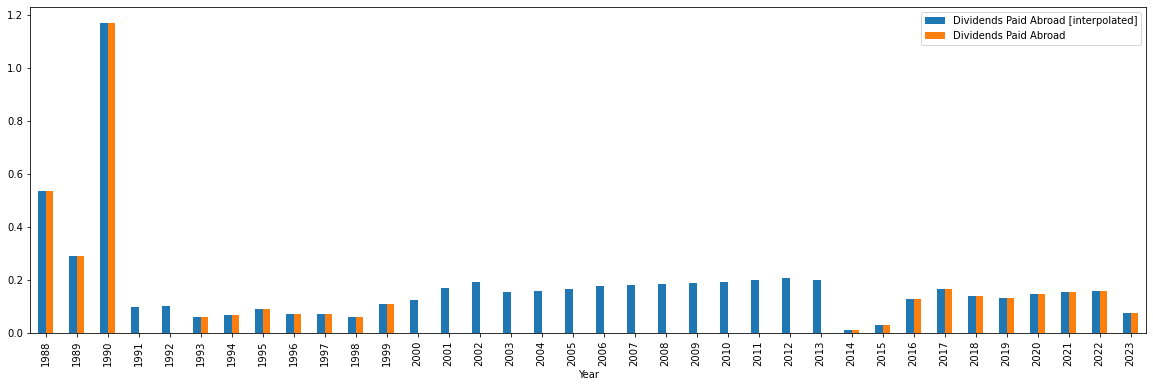

In [26]:
# Указать страну
country = 'Zimbabwe'
# Указать параметр(столбец)
column_interpolated = 'Dividends Paid Abroad [interpolated]'
column_manual = 'Dividends Paid Abroad'


df_output = pd.read_excel('./output.xlsx')
tmp = df_output[df_output['Country'] == country]
tmp = tmp[['Year', column_interpolated, column_manual]]
tmp.plot.bar(x='Year', figsize=(20, 6))